## Specifying the Simulation Environments

In [1]:
import os
os.getcwd()
os.chdir('D:/Github/CausalDM')
# import learner
from causaldm._util_causaldm import *
from scipy.linalg import block_diag
class Single_Gaussian_Env():
    @autoargs()
    def __init__(self, true_model, sigma, seed = 42, with_intercept = True, logged_dat = False):
        self.setting = locals()
        self.setting['self'] = None
        self.seed = seed
        np.random.seed(self.seed)
        
        self.true_model = true_model
        self.sigma = sigma
        
        if logged_dat:
            self.get_logged_dat()
            
        
    def get_Phi(self):
        """ consider the simple case now 
        [K, p]
        """
        occup = np.random.multinomial(1, [1/5, 1/5, 1/5, 1/5, 1/5], size=1)
        gender = np.random.binomial(1, 1/2, size=1)
        age = np.random.randint(low=20, high=60, size = 1)
        user_info = age.tolist()+gender.tolist()+occup.tolist()[0][:-1]
        if self.with_intercept:
            user_info = [1] + user_info
        self.Phi = block_diag(*([np.array(user_info)] * 5))   
        return self.Phi
    
    def get_reward(self, a):
        self.r_mean = self.Phi.dot(self.true_model)
        self.r = self.r_mean
        return self.r[a] + abs(np.random.randn(1)[0])*self.sigma
    
    def optimal_action_reward(self):
        a = np.argmax(self.r)
        return a
    
    def get_logged_dat(self):
        true_model = self.true_model.reshape((5,-1))
        occup = np.random.multinomial(1, [2/5, 3/5, 0, 0, 0], size=100)
        gender = np.random.binomial(1, 1/20, size=100).reshape(-1,1)
        age = np.random.randint(low=20, high=25, size = 100).reshape(-1,1)
        rec_genre = np.random.randint(low=0, high=5, size = 100).reshape(-1,1)
        user_info = pd.DataFrame(np.concatenate((age, gender, occup, rec_genre), axis=1))
        user_info.columns = ['age', 'gender', 'educator', 'student', 'executive', 'technician', 'others','rec_genre']
        user_info['reward'] = user_info.apply(lambda row : np.dot(true_model[row['rec_genre']],
                                                          np.array([1]+row.iloc[:-2].tolist()))+
                                              self.sigma*abs(np.random.randn(1)[0]), axis = 1)
        self.user_info = user_info

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Github/CausalDM'

### True Model

In [2]:
true_model = np.array([ 1.  ,  0.01, -0.5 ,  3.3 , -0.8 , -0.5 ,  4 ,  
                        1.5 ,  0.03,  -0.6 ,  1.4 ,  3.3 , -1 , -0.8 ,  
                        1.3 ,  0.015,  1.5 , -1.2 ,   2.6 ,  1.5 , -1 ,  
                        1.8 , -0.03,  2.1 , -1.3 ,  2.5 , 3.5, 1.3 ,  
                        1.9 , -0.02,  1.2 ,  1.5 , -1.1 ,  2 , -.6 ])
sigma = 1
true_model_1 = pd.DataFrame(true_model.reshape((5,-1)))
true_model_1.index = ['comedy', 'drama','action','thriller','scifi']
true_model_1.columns = ['inercept', 'age', 'gender', 'educator', 'student', 'executive', 'technician']
print(true_model_1.to_markdown())

|          |   inercept |    age |   gender |   educator |   student |   executive |   technician |
|:---------|-----------:|-------:|---------:|-----------:|----------:|------------:|-------------:|
| comedy   |        1   |  0.01  |     -0.5 |        3.3 |      -0.8 |        -0.5 |          4   |
| drama    |        1.5 |  0.03  |     -0.6 |        1.4 |       3.3 |        -1   |         -0.8 |
| action   |        1.3 |  0.015 |      1.5 |       -1.2 |       2.6 |         1.5 |         -1   |
| thriller |        1.8 | -0.03  |      2.1 |       -1.3 |       2.5 |         3.5 |          1.3 |
| scifi    |        1.9 | -0.02  |      1.2 |        1.5 |      -1.1 |         2   |         -0.6 |


## Offline Policy Optimization

In [7]:
from causaldm.learners.CPL13.disc import QLearning
seed = 0
user_info = Single_Gaussian_Env(true_model, sigma, seed = seed, with_intercept = True, logged_dat = True)
user_info = user_info.user_info
S = user_info[['age', 'gender', 'educator', 'student', 'executive', 'technician']]
A = user_info['rec_genre']
R = user_info['reward']

In [8]:
r_mean = block_diag(*([np.array([1,40,.5,1,0,0,0])] * 5)).dot(true_model).tolist()+ block_diag(
    *([np.array([1,40,.5,0,1,0,0])] * 5)).dot(true_model).tolist()+ block_diag(
    *([np.array([1,40,.5,0,0,1,0])] * 5)).dot(true_model).tolist()+ block_diag(
    *([np.array([1,40,.5,0,0,0,1])] * 5)).dot(true_model).tolist()+ block_diag(
    *([np.array([1,40,.5,0,0,0,0])] * 5)).dot(true_model).tolist() 
r_mean = np.array(r_mean).reshape((5,-1))
r_mean.T

array([[4.45, 0.35, 0.65, 5.15, 1.15],
       [3.8 , 5.7 , 1.4 , 1.6 , 2.4 ],
       [1.45, 5.25, 4.15, 1.65, 2.65],
       [0.35, 4.15, 5.15, 2.95, 1.65],
       [3.2 , 0.6 , 3.7 , 1.1 , 1.7 ]])

In [9]:
model_info = [{"model": "reward~C(rec_genre)*(age+gender+educator+student+executive+technician)", #default is add an intercept!!!
              'action_space':{'rec_genre':[0,1,2,3,4]}}]
#2. initialize the learner
QLearn = QLearning.QLearning()
#3. train the policy
QLearn.train(S, A, R, model_info, T=1)
#4. recommend action
opt_d = QLearn.recommend_action(S).value_counts()
#5. get the estimated value of the optimal regime
V_hat = QLearn.predict_value(S)
print("fitted model:",QLearn.fitted_model[0].params)
print("opt regime:",opt_d)
print("opt value:",V_hat)

fitted model: Intercept                       1.338373e+00
C(rec_genre)[T.1]               2.553173e+00
C(rec_genre)[T.2]               1.916054e+00
C(rec_genre)[T.3]               2.419341e-01
C(rec_genre)[T.4]              -4.574240e-01
age                             5.646757e-02
C(rec_genre)[T.1]:age          -7.578371e-02
C(rec_genre)[T.2]:age          -1.303934e-01
C(rec_genre)[T.3]:age          -4.339018e-02
C(rec_genre)[T.4]:age          -6.560132e-03
gender                          3.625256e-01
C(rec_genre)[T.1]:gender        3.893010e-16
C(rec_genre)[T.2]:gender        2.984154e-16
C(rec_genre)[T.3]:gender        3.818640e-16
C(rec_genre)[T.4]:gender        5.184398e-01
educator                        2.816416e+00
C(rec_genre)[T.1]:educator     -1.784788e+00
C(rec_genre)[T.2]:educator     -3.145633e+00
C(rec_genre)[T.3]:educator     -4.053477e+00
C(rec_genre)[T.4]:educator     -9.396107e-01
student                        -1.478043e+00
C(rec_genre)[T.1]:student       4.337961e

In [10]:
fitted_model = np.array(QLearn.fitted_model[0].params).reshape((7,-1)).T
fitted_model[1:,:] += fitted_model[0,:]
fitted_model = pd.DataFrame(fitted_model)
fitted_model.index = ['comedy', 'drama','action','thriller','scifi']
fitted_model.columns = ['inercept', 'age', 'gender', 'educator', 'student', 'executive', 'technician']
print(fitted_model.to_markdown())

|          |   inercept |        age |   gender |   educator |   student |   executive |   technician |
|:---------|-----------:|-----------:|---------:|-----------:|----------:|------------:|-------------:|
| comedy   |   1.33837  |  0.0564676 | 0.362526 |   2.81642  | -1.47804  |           0 |            0 |
| drama    |   3.89155  | -0.0193161 | 0.362526 |   1.03163  |  2.85992  |           0 |            0 |
| action   |   3.25443  | -0.0739259 | 0.362526 |  -0.329217 |  3.58364  |           0 |            0 |
| thriller |   1.58031  |  0.0130774 | 0.362526 |  -1.23706  |  2.81737  |           0 |            0 |
| scifi    |   0.880949 |  0.0499074 | 0.880965 |   1.87681  | -0.995856 |           0 |            0 |


## Online MAB

In [11]:
T = 1000
S = 100
p = len(true_model)
K = 5
sigma = 1
estimated_gamma = np.array(fitted_model).reshape(-1)
alpha = .1
exploration_T = K
Reward_Type = "Gaussian"
u_prior_mean = np.zeros(K)
u_prior_cov = 1000*np.identity(K)

In [41]:
#LINTS-informative
from causaldm.learners.CPL4.CMAB import LinTS, LinUCB
from causaldm.learners.CPL4.MAB import TS, UCB
sigma1 = 3
cum_reward_greedy = []
cum_reward_infoLinTS = []
cum_reward_uninfoLinTS = []
cum_reward_uninfoLinUCB = []
cum_reward_TS = []
cum_reward_UCB = []
for seed in range(S):
    ##Greedy
    env = Single_Gaussian_Env(true_model, sigma, seed = seed, with_intercept = True, logged_dat = False)
    cum_reward_greedy_t = []
    for t in range(T):
        X = env.get_Phi()
        A = np.argmax(X.dot(estimated_gamma))
        R = env.get_reward(A)
        cum_reward_greedy_t.append(R)
    cum_reward_greedy_t = np.cumsum(cum_reward_greedy_t)/(np.array(range(T))+1)
    cum_reward_greedy.append(cum_reward_greedy_t)
    
    ##info_LINTS
    env = Single_Gaussian_Env(true_model, sigma, seed = seed, with_intercept = True, logged_dat = False)
    prior_theta_u = np.array(estimated_gamma)
    prior_theta_cov = sigma1*np.identity(p)
    info_LinTS= LinTS.LinTS_Gaussian(sigma = sigma, prior_theta_u = prior_theta_u, 
                                                    prior_theta_cov = prior_theta_cov, 
                                                    K = K, p = p,seed = seed)
    cum_reward_infoLinTS_t = []
    for t in range(T):
        X = env.get_Phi()
        A = info_LinTS.take_action(X)
        R = env.get_reward(A)
        info_LinTS.receive_reward(t,A,R,X)
        cum_reward_infoLinTS_t.append(R)
    cum_reward_infoLinTS_t = np.cumsum(cum_reward_infoLinTS_t)/(np.array(range(T))+1)
    cum_reward_infoLinTS.append(cum_reward_infoLinTS_t)
    
    
    ##uninfo_LINTS
    env = Single_Gaussian_Env(true_model, sigma, seed = seed, with_intercept = True, logged_dat = False)
    prior_theta_u = 100*np.ones(p)
    prior_theta_cov = 200*np.identity(p)
    uninfo_LinTS= LinTS.LinTS_Gaussian(sigma = sigma, prior_theta_u = prior_theta_u, 
                                                    prior_theta_cov = prior_theta_cov, 
                                                    K = K, p = p,seed = seed)
    cum_reward_uninfoLinTS_t = []
    for t in range(T):
        X = env.get_Phi()
        A = uninfo_LinTS.take_action(X)
        R = env.get_reward(A)
        uninfo_LinTS.receive_reward(t,A,R,X)
        cum_reward_uninfoLinTS_t.append(R)
    cum_reward_uninfoLinTS_t = np.cumsum(cum_reward_uninfoLinTS_t)/(np.array(range(T))+1)
    cum_reward_uninfoLinTS.append(cum_reward_uninfoLinTS_t)
    
    ##uninfo_LINUCB
    env = Single_Gaussian_Env(true_model, sigma, seed = seed, with_intercept = True, logged_dat = False)
    uninfo_LinUCB= LinUCB.LinUCB_Gaussian(alpha = alpha, K = K, p = p, seed = seed, 
                                                                 exploration_T = exploration_T)
    cum_reward_uninfoLinUCB_t = []
    for t in range(T):
        X = env.get_Phi()
        A = uninfo_LinUCB.take_action(X)
        R = env.get_reward(A)
        uninfo_LinUCB.receive_reward(t,A,R,X)
        cum_reward_uninfoLinUCB_t.append(R)
    cum_reward_uninfoLinUCB_t = np.cumsum(cum_reward_uninfoLinUCB_t)/(np.array(range(T))+1)
    cum_reward_uninfoLinUCB.append(cum_reward_uninfoLinUCB_t)
    
    
    ##TS
    env = Single_Gaussian_Env(true_model, sigma, seed = seed, with_intercept = True, logged_dat = False)
    uninfo_TS= TS.TS(Reward_Type = Reward_Type, sigma = sigma, 
                          u_prior_mean = u_prior_mean, u_prior_cov = u_prior_cov, 
                          seed = seed)
    cum_reward_TS_t = []
    for t in range(T):
        X = env.get_Phi()
        A = uninfo_TS.take_action()
        R = env.get_reward(A)
        uninfo_TS.receive_reward(t,A,R)
        cum_reward_TS_t.append(R)
    cum_reward_TS_t = np.cumsum(cum_reward_TS_t)/(np.array(range(T))+1)
    cum_reward_TS.append(cum_reward_TS_t)
    
    ##UCB
    env = Single_Gaussian_Env(true_model, sigma, seed = seed, with_intercept = True, logged_dat = False)
    uninfo_UCB= UCB.UCB1(K)
    cum_reward_UCB_t = []
    for t in range(T):
        X = env.get_Phi()
        A = uninfo_UCB.take_action()
        R = env.get_reward(A)
        uninfo_UCB.receive_reward(t,A,R)
        cum_reward_UCB_t.append(R)
    cum_reward_UCB_t = np.cumsum(cum_reward_UCB_t)/(np.array(range(T))+1)
    cum_reward_UCB.append(cum_reward_UCB_t)
    
    

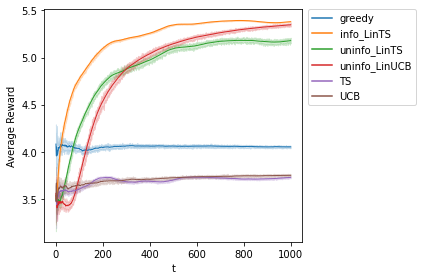

In [42]:
import seaborn as sns
result = pd.DataFrame({'rep':np.concatenate([np.ones(T)*rep for rep in range(S)]*6),
                       't':np.concatenate([range(T)]*6*S),
                       'Reward':np.concatenate(cum_reward_greedy+
                                               cum_reward_infoLinTS+
                                               cum_reward_uninfoLinTS+
                                               cum_reward_uninfoLinUCB+
                                               cum_reward_TS+
                                               cum_reward_UCB),
                       'Algo':['greedy']*T*S+['info_LinTS']*T*S+['uninfo_LinTS']*T*S+['uninfo_LinUCB']*T*S+['TS']*T*S+['UCB']*T*S})
sns.lineplot(data=result[result.t>0], x='t', y="Reward", hue="Algo", ci = 95,
             n_boot = 20, linewidth = 1.0, markers = False)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Average Reward')
plt.tight_layout()
plt.savefig('MovieLens_Contextual.png')

In [36]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>